# HW2 - Data From The Web

## 1. Web Scraping 

We will first write all functions needed to extract the data from the websites and demonstrate how they work. Then we will complete the assignment using them.

In [1]:
import requests as rq
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import seaborn
import pickle
%matplotlib inline
import os.path
from googletrans import Translator
import time


TOP_UNI_URL = 'https://www.topuniversities.com'
TIMES_URL = 'https://www.timeshighereducation.com'

## Helper functions

#### Create dataframe with the scrapped information 

In [2]:
def create_dataframe(data):
    df = pd.DataFrame.from_dict(data).set_index('Rank')
    df = df[['Name', 'Country', 'Region', 'Tot_Stud', 'Inter_Stud', 'Tot_Mem', 'Inter_Mem']]
    return df

#### Calculate Member/Student ratio dataframe

In [3]:
def best_member_student_ratio(df):
    best_ratio = df.copy()
    best_ratio['Members/Students ratio'] =df['Tot_Mem'] / df['Tot_Stud']
    best_ratio = best_ratio.set_index('Name').sort_values(['Members/Students ratio'], ascending=False)
    
    best_ratio[:20]['Members/Students ratio'].plot.bar(title='Top 20 Universities on Member/Student ratio')
    plt.show()
    return best_ratio

#### Calculate International/Student ratio dataframe

In [4]:
def best_international_student_ratio(df):
    best_ratio = df.copy()
    best_ratio['Int_Stud ratio'] = df['Inter_Stud'] / df['Tot_Stud']
    best_ratio = best_ratio.set_index('Name').sort_values(['Int_Stud ratio'], ascending=False)
    best_ratio[:20]['Int_Stud ratio'].plot.bar(title='Top 20 Universities on Member/Student ratio')
    plt.show()
    return best_ratio

#### Plot ratios by country and region

In [5]:
def plot_ratios_by_country_region(member_student, international_student): 
    plot_country_df_a = member_student.groupby(['Country'])['Members/Students ratio'].mean()
    plot_country_df_a = plot_country_df_a.sort_values(ascending=False)

    plot_country_df_b = international_student.groupby(['Country'])['Int_Stud ratio'].mean()
    plot_country_df_b = plot_country_df_b.sort_values(ascending=False)

    plot_region_df_a = member_student.groupby(['Region'])['Members/Students ratio'].mean()
    plot_region_df_a = plot_region_df_a.sort_values(ascending=False)

    plot_region_df_b = international_student.groupby(['Region'])['Int_Stud ratio'].mean()
    plot_region_df_b = plot_region_df_b.sort_values(ascending=False)

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.subplots_adjust(hspace = 1)
    plot_country_df_a.plot.bar(ax=axes[0, 0], title='Member/Student ratio by country')
    plot_country_df_b.plot.bar(ax=axes[0, 1], title='International Student ratio by Country')
    plot_region_df_a.plot.bar(ax=axes[1, 0], title='Member/Student ratio by region')
    plot_region_df_b.plot.bar(ax=axes[1, 1], title='International Student ratio by Region')
    plt.show()
    

Here we transform the names of the universities with `clean_name` and we merge the two frames together. We perform an inner join in order to keep only universities that have correspondance in the two data frames

In [6]:
import re

def rreplace(s):
    d = {}
    
    for w in s.split(): 
        w = w.strip(' ')
        
        if w in d.keys(): 
            d[w] += 1
        else:
            d[w] = 0
    
    for key, value in d.items():
        li = s.rsplit(key, value)
        s = ''.join(li)
    
    return s.strip()

def clean_name(name):
    to_replace = {'the':'', 'of':'', 'é':'e', '-':' ', '—':' ', '–':' ', '’':'',\
                  '\'':'', '.':'', ',':'', '&':' and ', '(':'', ')':''}
    
    translator = Translator(service_urls=[
        'translate.google.ch'
    ])
    
    name = translator.translate(name).text
    name = name.lower()
    #name = re.sub(r"\(.+\)", ' ', name)
    name = rreplace(name)
    
    for key, value in to_replace.items(): 
        name = name.replace(key, value)
    
    name = re.sub(r"\s+", ' ', name)
    name = name.strip(' ')
    print(name)
    
    return name

### 1.1 Top Universities Website

Here are the functions to obtain the amount of faculty members (total & international) and students (total & international)

In [7]:
def get_num_members(soup):
    return int(soup.find('div', class_='total faculty').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='inter faculty').find('div', class_='number').text.strip().replace(',', ''))

In [8]:
def get_num_students(soup):
    return int(soup.find('div', class_='total student').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='total inter').find('div', class_='number').text.strip().replace(',', ''))

After a quick look with Postman on the webside, we realised that the ranking table data were not given on the page but retrieved and added with a script on a json file. We then had to directly get this file to obtain the information we need for this assignment. The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag.

In [9]:
names = []
g = 0
if not os.path.exists('topunis.pickle'): 
    TOP_WORLD_RANKING_FILE = TOP_UNI_URL + '/sites/default/files/qs-rankings-data/357051.txt'
    ranking_top_uni = rq.get(TOP_WORLD_RANKING_FILE).json().get('data')
    top_unis = []
    for uni in ranking_top_uni[:200]:
        g +=1
        
        # throttling the research to avoid being kicked by the website
        if g % 20 == 0: 
            time.sleep(10)
        name = clean_name(uni.get('title'))
        names.append(name)
        top_unis.append({'Name' : name, 'Rank' : uni.get('rank_display').replace('=', ''), 
                         'Country' : uni.get('country'), 'Region' : uni.get('region'), 'Url' : uni.get('url')})
        
    problematic_uni = []
    for uni in top_unis:
        page = rq.get(TOP_UNI_URL + uni['Url'])
        soup = BeautifulSoup(page.text, 'html.parser')
        try:
            tot_mem, inter_mem = get_num_members(soup)
            tot_stud, inter_stud = get_num_students(soup)
            uni['Tot_Mem'] = tot_mem
            uni['Inter_Mem'] = inter_mem
            uni['Tot_Stud'] = tot_stud
            uni['Inter_Stud'] = inter_stud
        except AttributeError: 
            problematic_uni.append(top_unis.index(uni))
            print('Could not fetch data from:', uni['Name'])
    #Fill in the missing information for "problematic unis"
    nyu = top_unis[problematic_uni[0]]
    nyu['Tot_Mem'] = 7717
    nyu['Inter_Mem'] = 604
    nyu['Tot_Stud'] = 43860
    nyu['Inter_Stud'] = 11593

    bang = top_unis[problematic_uni[1]]
    bang['Tot_Mem'] = 423
    bang['Inter_Mem'] = 0
    bang['Tot_Stud'] = 4071
    bang['Inter_Stud'] = 47
    
    with open('topunis.pickle', 'wb') as out:
        pickle.dump(top_unis, out)
else: 
    with open('topunis.pickle', 'rb') as data: 
        top_unis = pickle.load(data)

In [10]:
top_uni_df = create_dataframe(top_unis)

#### 1.2.a Which are the best universities in terms of ratio between faculty members and students ?
Here are the top 20

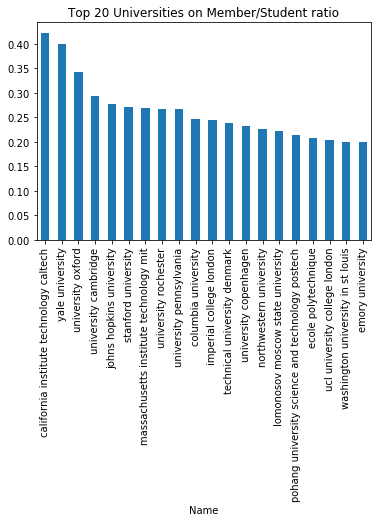

In [11]:
member_student_ratio = best_member_student_ratio(top_uni_df)

#### 1.2.b Which are the best universities in terms of ratio of international students?
Here are the top 20

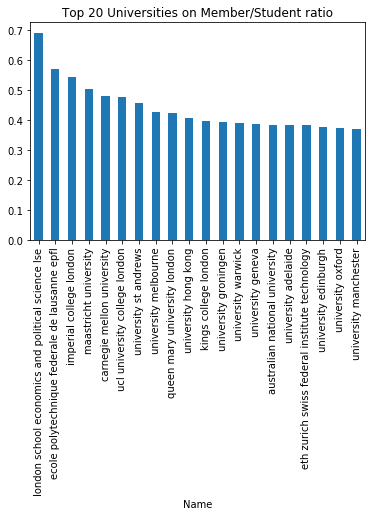

In [12]:
international_student_ratio = best_international_student_ratio(top_uni_df)

#### 1.2.c and 1.2.d Same questions aggregating by country:

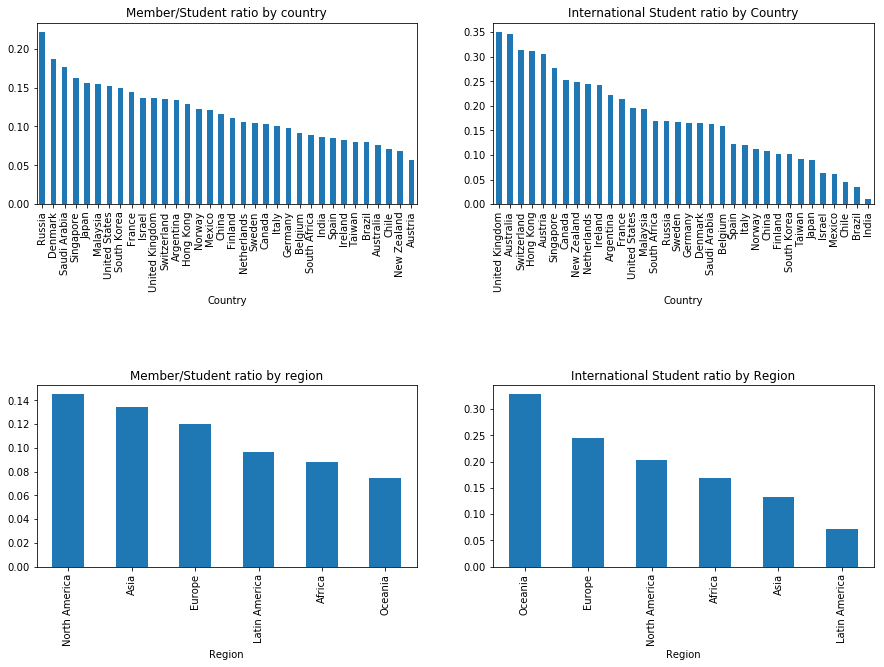

In [13]:
# TODO same y-axis
plot_ratios_by_country_region(member_student_ratio, international_student_ratio)

### 2.1 Times Higher Education Website

The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag. But this time the *Region* is not given by the website, no even on the specific pages. But this time it contains everything else, no need to scrap the specific pages.

In [14]:
if not os.path.exists('toptimes.pickle'): 
    
    TOP_TIMES_RANKING_FILE = TIMES_URL + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
    ranking_top_times = rq.get(TOP_TIMES_RANKING_FILE).json().get('data')

    top_times = []
    for uni in ranking_top_times[:200]:
        g +=1
        # throttling the research to avoid being kicked by the website
        if g % 50 == 0: 
            time.sleep(30)
            
        name = clean_name(uni.get('name'))
        for n in names: 
            if name in n: 
                name = n
                break
            elif n in name: 
                name = n
                break
        top_times.append({'Name' : name, 'Rank' : uni.get('rank').replace('=', ''), 
                          'Country' : uni.get('location'), 'Region' : None,
                          'Tot_Stud' : int(uni.get('stats_number_students').replace(',', '')), 
                          'Inter_Stud' : round(int(uni.get('stats_number_students').replace(',', '')) * int(uni.get('stats_pc_intl_students').replace('%', '')) / 100),
                          'Tot_Mem' : round(int(uni.get('stats_number_students').replace(',', '')) / float(uni.get('stats_student_staff_ratio'))),
                          'Inter_Mem' : None})
    with open('toptimes.pickle', 'wb') as out:
        pickle.dump(top_times, out)
else: 
    with open('toptimes.pickle', 'rb') as data: 
        top_times = pickle.load(data)
    

In [15]:
top_times_df = create_dataframe(top_times)
top_times_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,university oxford,United Kingdom,None,20409,7755,1822,None
2,university cambridge,United Kingdom,None,18389,6436,1687,None
3,california institute technology caltech,United States,None,2209,596,340,None
3,stanford university,United States,None,15845,3486,2113,None
5,massachusetts institute technology mit,United States,None,11177,3800,1285,None


### Fill in the regions for the top times dataframe from top uni dataframe

To do this task we take the unique $country \mapsto region$ mappings from the first ranking. We can see that in the Top Universities ranking Luxembourg doesn't appear, so we have to map it by hand. Also Russia appears as `Russia` in the Top Universities ranking and as `Russian Federation` in the Top Times rankings. We also map it separately to have Europe as region. 

In [16]:
df = top_uni_df[['Country', 'Region']].groupby(['Country','Region'])

country_region = {}
for country, region in df.groups.keys(): 
    top_times_df.loc[top_times_df['Country'] == country, 'Region'] = region
    
top_times_df.loc[top_times_df['Country'] == 'Luxembourg', 'Region'] = 'Europe'
top_times_df.loc[top_times_df['Country'] == 'Russian Federation', 'Region'] = 'Europe'

top_times_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,university oxford,United Kingdom,Europe,20409,7755,1822,None
2,university cambridge,United Kingdom,Europe,18389,6436,1687,None
3,california institute technology caltech,United States,North America,2209,596,340,None
3,stanford university,United States,North America,15845,3486,2113,None
5,massachusetts institute technology mit,United States,North America,11177,3800,1285,None


#### 2.2.a Which are the best universities in terms of ratio between faculty members and students ?
Here are the top 20

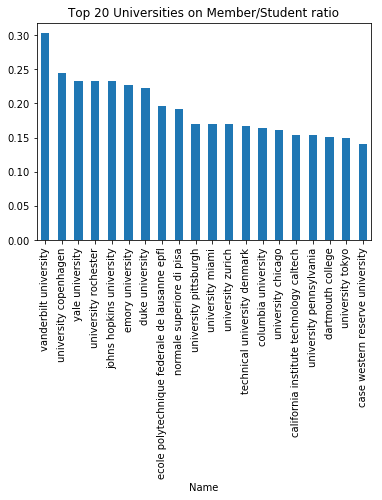

In [17]:
member_student_ratio = best_member_student_ratio(top_times_df)

#### 2.2.b Which are the best universities in terms of ratio of international students?
Here are the top 20

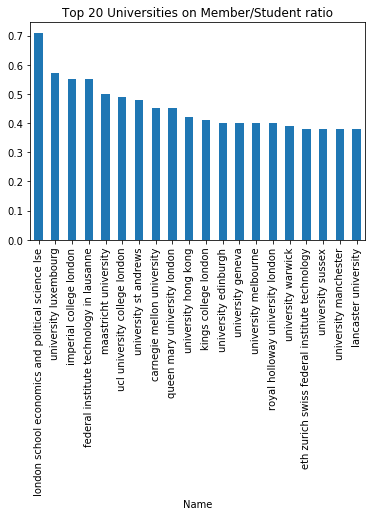

In [18]:
international_student_ratio = best_international_student_ratio(top_times_df)

#### 2.2.c and 2.2.d Same questions aggregating by country and region

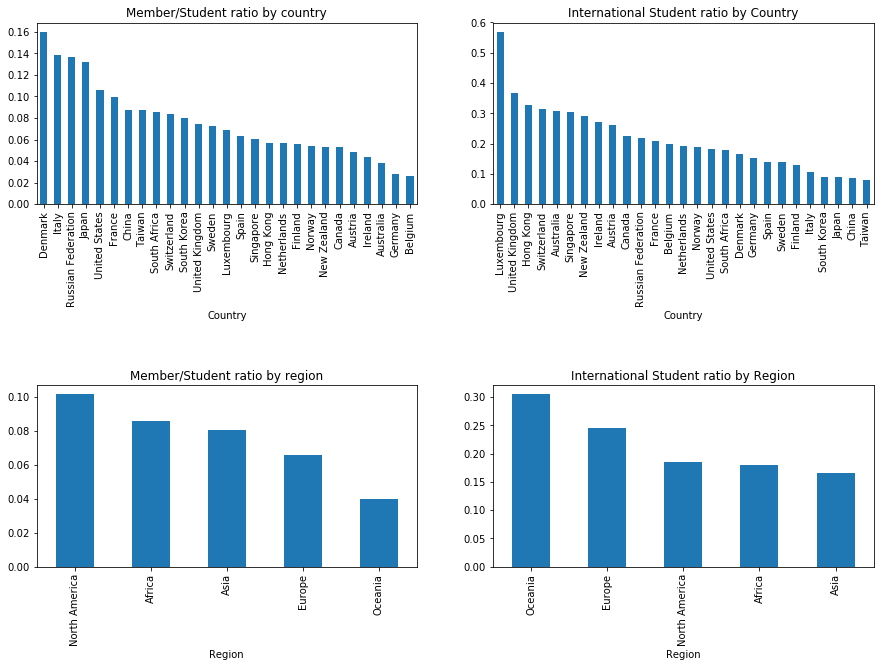

In [19]:
 plot_ratios_by_country_region(member_student_ratio, international_student_ratio)

### 3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

This function prepare the names for the merge. We noticed that in one of the rankings the name is present as well as an abreviation of the university name. For exemple "Ecole polytechnique federale de lausanne (EPFL)" and in the othe rankng the abreviation was not present. Because of that we remove all abreviations of that type. We also remove some types of ponctuation and blank spaces.  

In [133]:
merged_df = top_times_df.reset_index().merge(top_uni_df.reset_index(), on=['Name'], suffixes=('_Times', '_Unis'), how='inner')
merged_df.head()
merged_df["Rank_Times"] = pd.to_numeric(merged_df["Rank_Times"])
merged_df["Rank_Unis"] = pd.to_numeric(merged_df["Rank_Unis"])
merged_df

,Rank_Times,Name,Country_Times,Region_Times,Tot_Stud_Times,Inter_Stud_Times,Tot_Mem_Times,Inter_Mem_Times,Rank_Unis,Country_Unis,Region_Unis,Tot_Stud_Unis,Inter_Stud_Unis,Tot_Mem_Unis,Inter_Mem_Unis
0,1,university oxford,United Kingdom,Europe,20409,7755,1822,None,6,United Kingdom,Europe,19720,7353,6750,2964
1,2,university cambridge,United Kingdom,Europe,18389,6436,1687,None,5,United Kingdom,Europe,18770,6699,5490,2278
2,3,california institute technology caltech,United States,North America,2209,596,340,None,4,United States,North America,2255,647,953,350
3,3,stanford university,United States,North America,15845,3486,2113,None,2,United States,North America,15878,3611,4285,2042
4,5,massachusetts institute technology mit,United States,North America,11177,3800,1285,None,1,United States,North America,11067,3717,2982,1679
5,6,harvard university,United States,North America,20326,5285,2284,None,3,United States,North America,22429,5266,4350,1311
6,7,princeton university,United States,North America,7955,1909,958,None,13,United States,North America,8069,1793,1007,246
7,8,imperial college london,United Kingdom,Europe,15857,8721,1391,None,8,United Kingdom,Europe,16090,8746,3930,2071
8,9,university chicago,United States,North America,13525,3381,2181,None,9,United States,North America,13557,3379,2449,635
9,10,eth zurich swiss federal institute technology,Switzerland,Europe,19233,7309,1317,None,10,Switzerland,Europe,19815,7563,2477,1886


### 4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

In [35]:
merged_df.corr()

,Rank_Times,Tot_Stud_Times,Inter_Stud_Times,Tot_Mem_Times,Rank_Unis,Tot_Stud_Unis,Inter_Stud_Unis,Tot_Mem_Unis,Inter_Mem_Unis
Rank_Times,1.000000,-0.143741,-0.282913,-0.218701,0.683172,-0.139177,-0.254301,-0.363867,-0.345160
Tot_Stud_Times,-0.143741,1.000000,0.552027,0.536675,-0.009898,0.977286,0.556018,0.589580,0.227651
Inter_Stud_Times,-0.282913,0.552027,1.000000,0.201871,-0.277108,0.567167,0.911385,0.396175,0.493071
Tot_Mem_Times,-0.218701,0.536675,0.201871,1.000000,-0.245471,0.518367,0.183852,0.740882,0.257847
Rank_Unis,0.683172,-0.009898,-0.277108,-0.245471,1.000000,-0.016616,-0.281441,-0.370477,-0.535086
Tot_Stud_Unis,-0.139177,0.977286,0.567167,0.518367,-0.016616,1.000000,0.608226,0.576516,0.234866
Inter_Stud_Unis,-0.254301,0.556018,0.911385,0.183852,-0.281441,0.608226,1.000000,0.409418,0.557608
Tot_Mem_Unis,-0.363867,0.589580,0.396175,0.740882,-0.370477,0.576516,0.409418,1.000000,0.595837
Inter_Mem_Unis,-0.345160,0.227651,0.493071,0.257847,-0.535086,0.234866,0.557608,0.595837,1.000000


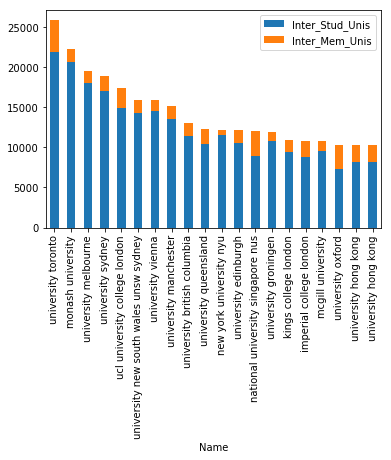

In [36]:
best_ratio  =merged_df.copy()
best_ratio['International'] = merged_df['Inter_Stud_Unis'] +  merged_df['Inter_Mem_Unis']
best_ratio = best_ratio.set_index('Name').sort_values(['International'], ascending=False)
    
top_20 = best_ratio[['Inter_Stud_Unis', 'Inter_Mem_Unis']][:20]
top_20[['Inter_Stud_Unis','Inter_Mem_Unis']].plot.bar(stacked=True)
plt.show()

In [23]:
rank_no_students = merged_df.set_index('Rank_Times')
#rank_no_students['Tot_Stud_Times'].plot(title='', style=".")
#plt.show()
rank_no_students = merged_df.set_index('Rank_Unis').sort_index()
#rank_no_students['Tot_Stud_Unis'].plot(title='', style=".")
#plt.show()

#merged_df.plot(kind="scatter", x="Rank_Times", y="Tot_Stud_Times")

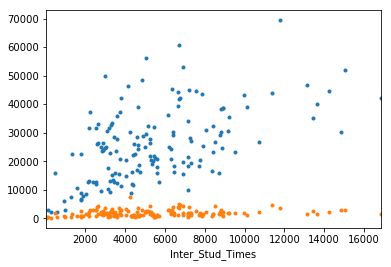

In [24]:
rank_no_students = merged_df.set_index('Inter_Stud_Times').sort_index()
rank_no_students['Tot_Stud_Times'].plot(title='', style=".")
rank_no_students['Tot_Mem_Times'].plot(title='', style=".")
plt.show()

Scatter plot

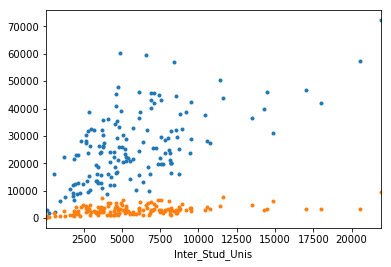

In [25]:
rank_no_students = merged_df.set_index('Inter_Stud_Unis').sort_index()
rank_no_students['Tot_Stud_Unis'].plot(title='', style=".")
rank_no_students['Tot_Mem_Unis'].plot(title='', style=".")
plt.show()

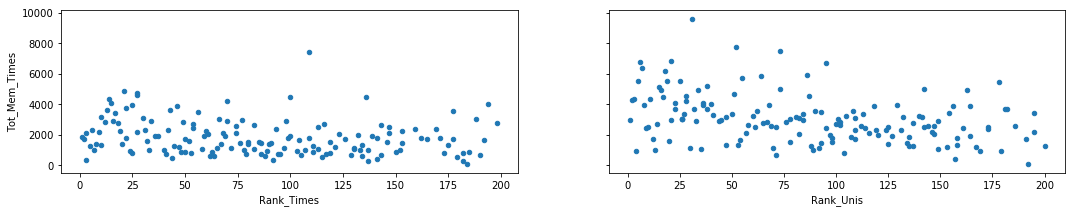

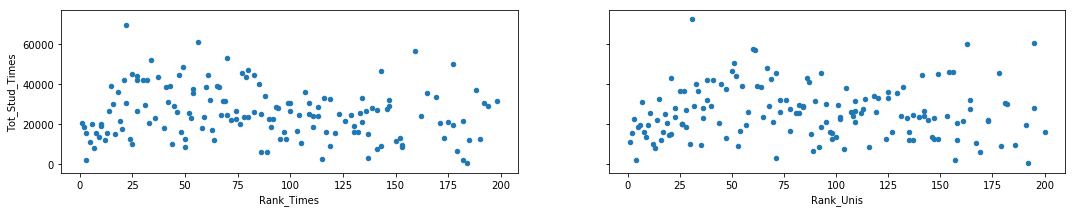

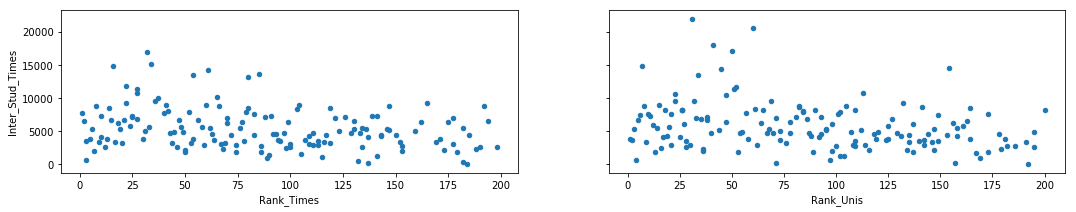

In [49]:
# Relation between the amount of student and the ranking

height = 3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,height), sharey=True)

merged_df.plot(kind="scatter", x="Rank_Times", y="Tot_Mem_Times", ax=axes[0])
merged_df.plot(kind="scatter", x="Rank_Unis", y="Tot_Mem_Unis", ax=axes[1])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,height), sharey=True)
merged_df.plot(kind="scatter", x="Rank_Times", y="Tot_Stud_Times", ax=axes[0])
merged_df.plot(kind="scatter", x="Rank_Unis", y="Tot_Stud_Unis", ax=axes[1])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,height), sharey=True)
merged_df.plot(kind="scatter", x="Rank_Times", y="Inter_Stud_Times", ax=axes[0])
merged_df.plot(kind="scatter", x="Rank_Unis", y="Inter_Stud_Unis", ax=axes[1])
plt.show()

[]

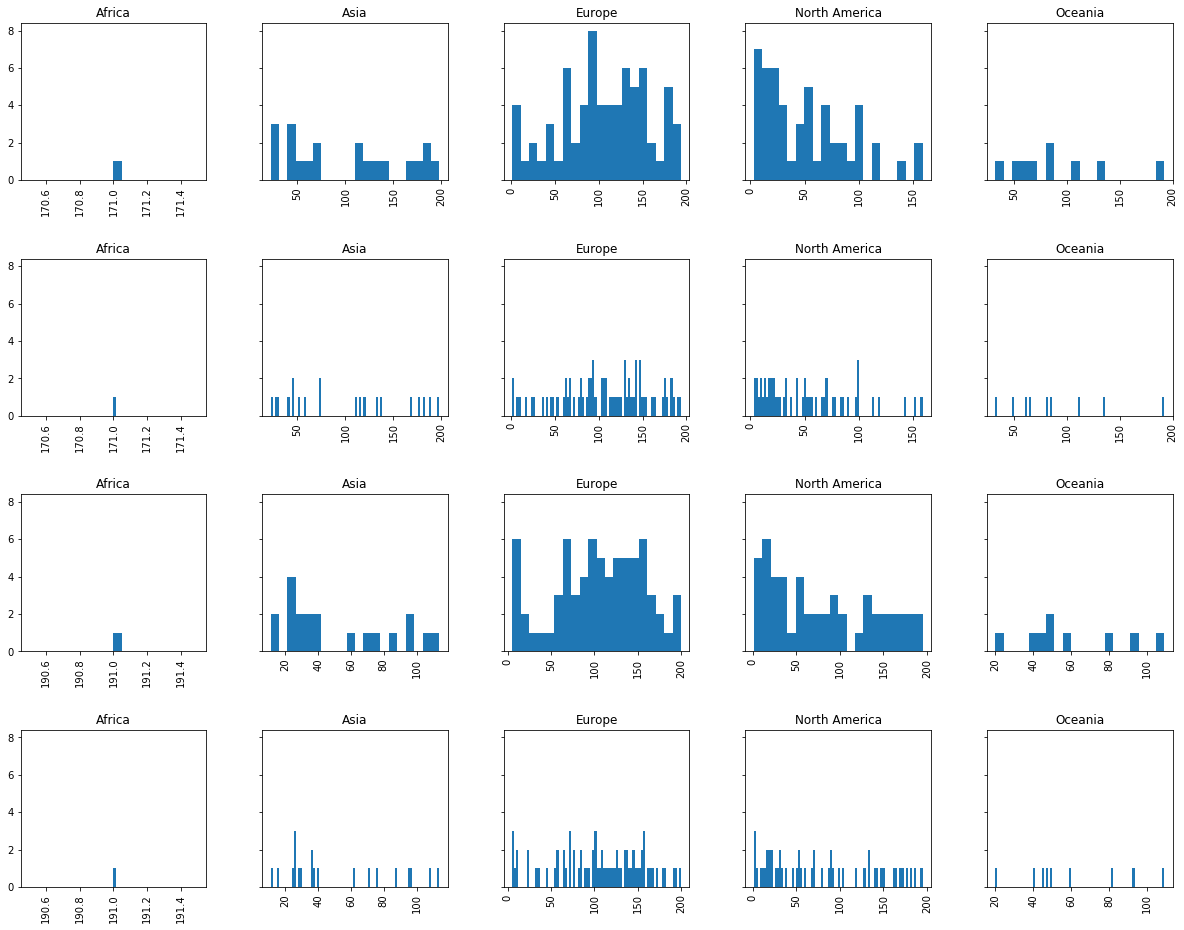

In [134]:
# Relation between the region and the ranking

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,16), sharey=True)

merged_df.hist(column="Rank_Times", by="Region_Times", bins=20, ax=axes[0])
merged_df.hist(column="Rank_Times", by="Region_Times", bins=80, ax=axes[1])

merged_df.hist(column="Rank_Unis", by="Region_Unis", bins=20, ax=axes[2])
merged_df.hist(column="Rank_Unis", by="Region_Unis", bins=80, ax=axes[3])

plt.plot()



[]

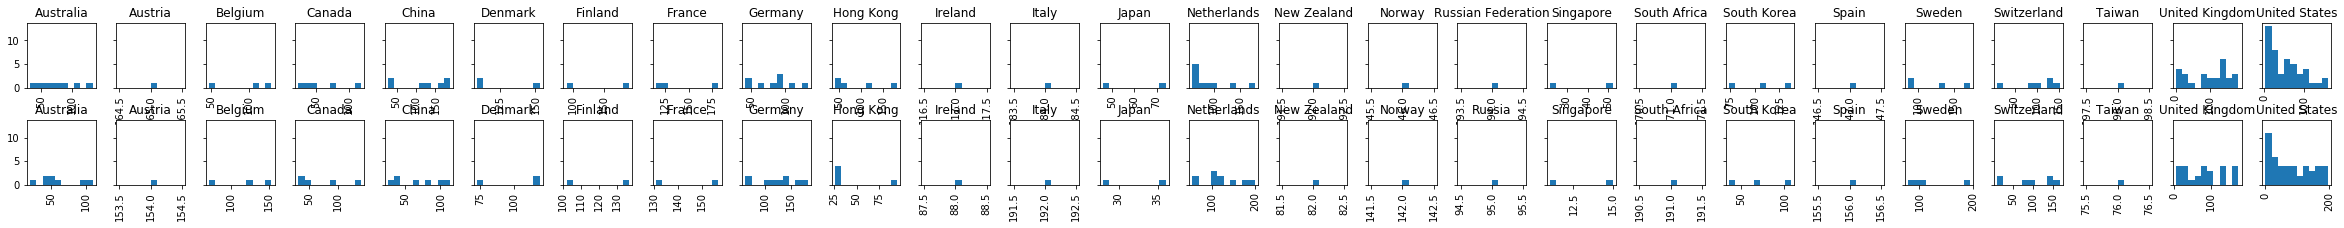

In [96]:
# Relation between the country and the ranking
fig, axes = plt.subplots(nrows=2, ncols=26, figsize=(40,3), sharey=True)

merged_df.hist(column="Rank_Times", by="Country_Times", bins=10, ax=axes[0])
merged_df.hist(column="Rank_Unis", by="Country_Unis", bins=10, ax=axes[1])

plt.plot()



[]

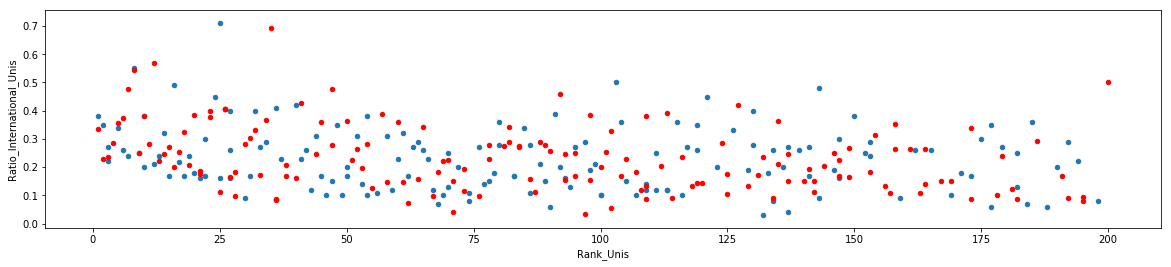

In [177]:
# Relation between the ratio of international student and the region/country

merged_df["Ratio_International_Times"] = merged_df['Inter_Stud_Times'] / merged_df['Tot_Stud_Times']
merged_df["Ratio_International_Unis"] = merged_df['Inter_Stud_Unis'] / merged_df['Tot_Stud_Unis']



#merged_df["Ratio_International_Times"] = merged_df["Ratio_International_Times"].apply(lambda x: np.log2(x*100))
#merged_df["Ratio_International_Unis"] = merged_df["Ratio_International_Unis"].apply(lambda x: np.log2(x*100))

#plt.figure()
ax = merged_df.plot(kind="scatter", x="Rank_Times", y="Ratio_International_Times", figsize=(20,4))
merged_df.plot(kind="scatter", x="Rank_Unis", y="Ratio_International_Unis", ax=ax, color="r")

#merged_df.plot(kind="scatter", x="Rank_Times", y="Ratio_International_Unis")
plt.plot()
# Relation between the ratio of member/student given the ranking/country

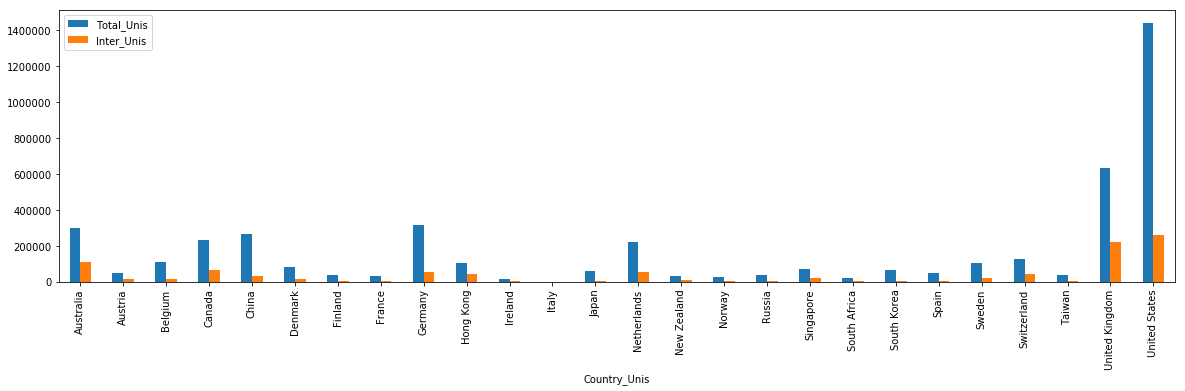

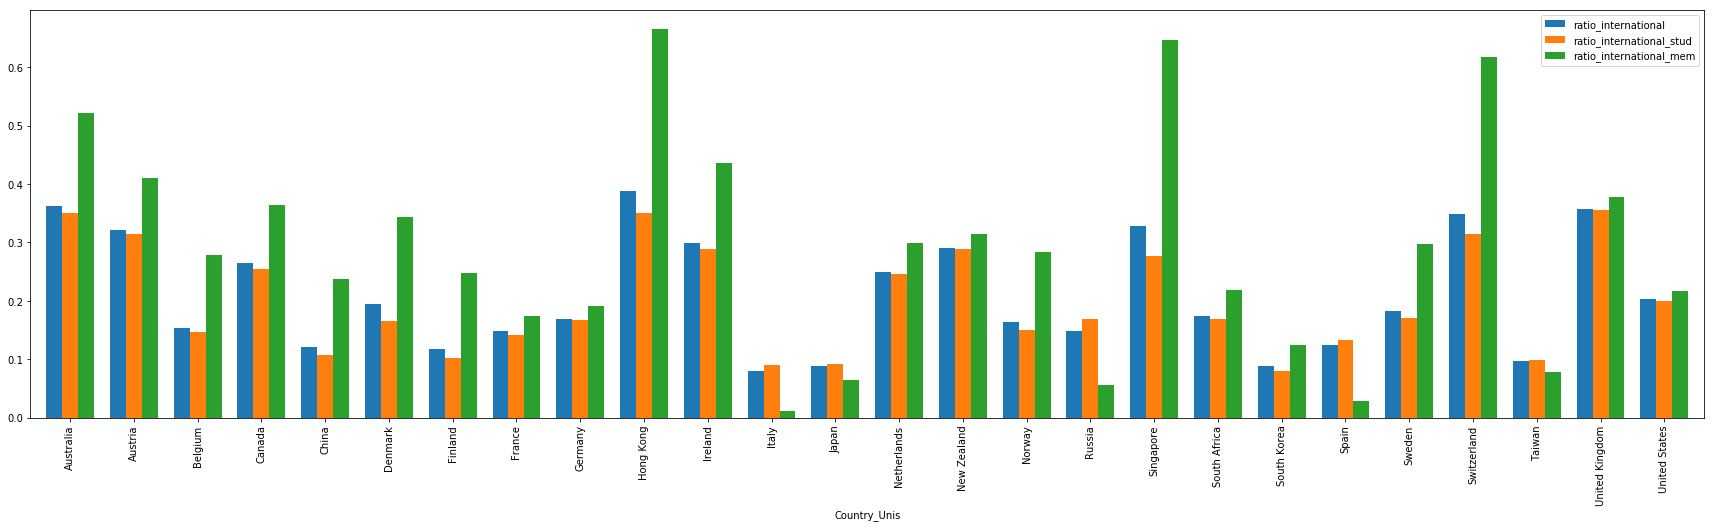

In [259]:
#fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,2*3), sharex=True)

merged_df["Total_Unis"] = merged_df["Tot_Stud_Unis"] + merged_df["Tot_Mem_Unis"]
merged_df["Inter_Unis"] = merged_df["Inter_Stud_Unis"] + merged_df["Inter_Mem_Unis"]
#Tot_Stud_Unis 	Inter_Stud_Unis 	Tot_Mem_Unis 	Inter_Mem_Unis

merged_df["ratio_international"] = merged_df["Inter_Unis"] / merged_df["Total_Unis"]
merged_df["ratio_international_stud_total"] = merged_df["Inter_Stud_Unis"] / merged_df["Total_Unis"]
merged_df["ratio_international_mem_total"] = merged_df["Inter_Mem_Unis"] / merged_df["Total_Unis"]
merged_df["ratio_international_stud"] = merged_df["Inter_Stud_Unis"] / merged_df["Tot_Stud_Unis"]
merged_df["ratio_international_mem"] = merged_df["Inter_Mem_Unis"] / merged_df["Tot_Mem_Unis"]

#merged_df.hist(column="Inter_Unis", by="Region_Unis", bins=20, layout=(1,5), figsize=(15,2), sharey=True, sharex=True)
#merged_df.hist(column="Inter_Stud_Unis", by="Region_Unis", bins=20, layout=(1,5), figsize=(15,2), sharey=True, sharex=True)
#merged_df.hist(column="Inter_Mem_Unis", by="Region_Unis", bins=20, layout=(1,5), figsize=(15,2), sharey=True, sharex=True)

#fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,2*3), sharex=True)
#merged_df.hist(column="Total_Unis", by="Region_Unis", bins=20, ax=axes[0])
#merged_df.hist(column="Inter_Stud_Unis", by="Region_Unis", bins=20, ax=axes[1])
#merged_df.hist(column="Inter_Mem_Unis", by="Region_Unis", bins=20, ax=axes[2])

merged_df.groupby("Country_Unis").sum().plot.bar(y=["Total_Unis", "Inter_Unis"], figsize=(20,5))
merged_df.groupby("Country_Unis").mean().plot.bar(y=["ratio_international", "ratio_international_stud", "ratio_international_mem"], width=0.75, figsize=(30,7.5))
